In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils import class_weight

In [6]:
# Load normal ECG data from text file
def load_normal_ecg_data(file_path):
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        ecg_data = []
        labels = []

        for line in lines:
            try:
                values = list(map(float, line.strip().split()))
                if len(values) > 0:
                    ecg_data.append(values)
                    labels.append(0)  # Normal ECG labels as 0
            except ValueError:
                continue

        return np.array(ecg_data), np.array(labels)

    except Exception as e:
        print(f"Error loading normal ECG file {file_path}: {e}")
        return None, None

In [7]:
# Load arrhythmia ECG data from folders
def load_arrhythmia_ecg_data(root_folder):
    all_data = []
    all_labels = []

    for subdir, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith('.mat'):
                file_path = os.path.join(subdir, file)
                try:
                    mat_data = loadmat(file_path)
                    if 'val' in mat_data:
                        ecg_data = mat_data['val']  # Assuming shape (12, 5000)
                        lead_1_data = ecg_data[0]  # Extract Lead 1 data (shape: (5000,))
                        all_data.append(lead_1_data)
                        label = int(file.split('_')[1]) if '_' in file else 1  # Map any arrhythmia to 1
                        all_labels.append(label)
                except Exception as e:
                    print(f"Error loading MATLAB file {file_path}: {e}")

    return np.array(all_data), np.array(all_labels)

In [8]:
# Load datasets
normal_file_path = r'C:\Users\diyu2\OneDrive - AUT University\AUT YEAR 4\INDUSTRIAL PROJECT (Mechanical)\Reports Part B\testing_ecg.txt'
arrhythmia_root_folder = r'C:\Users\diyu2\OneDrive - AUT University\AUT YEAR 4\INDUSTRIAL PROJECT (Mechanical)\Reports Part B\ECG database-for-arrhythmia\WFDBRecords'

normal_ecg_data, normal_labels = load_normal_ecg_data(normal_file_path)
arrhythmia_ecg_data, arrhythmia_labels = load_arrhythmia_ecg_data(arrhythmia_root_folder)

# Display the shapes before reshaping
print(f"Normal Data Shape (Before): {normal_ecg_data.shape}")         # (5000, 12)
print(f"Arrhythmic Data Shape: {arrhythmia_ecg_data.shape}")          # (5000, 5000)

# Pad normal ECG data to have the same second dimension size as arrhythmic ECG data
padding_length = arrhythmia_ecg_data.shape[1] - normal_ecg_data.shape[1]  # 5000 - 12 = 4988
normal_ecg_data_padded = np.pad(normal_ecg_data, ((0, 0), (0, padding_length)), 'constant')

# Verify the new shape
print(f"Normal Data Shape (After Padding): {normal_ecg_data_padded.shape}")  # (5000, 5000)

# Combine datasets
X = np.concatenate((normal_ecg_data_padded, arrhythmia_ecg_data), axis=0)
y = np.concatenate((normal_labels, arrhythmia_labels), axis=0)

# Check the shape of the combined data
print(f'Combined ECG data shape: {X.shape}')   # (10000, 5000)
print(f'Combined labels shape: {y.shape}')     # (10000,)

Normal Data Shape (Before): (5000, 12)
Arrhythmic Data Shape: (5000, 5000)
Normal Data Shape (After Padding): (5000, 5000)
Combined ECG data shape: (10000, 5000)
Combined labels shape: (10000,)


In [9]:
# Map arrhythmia labels to 1 and keep normal labels as 0
# Assuming all arrhythmia_labels are already 1
# If there are multiple classes, map them to 1
y = np.concatenate((normal_labels, np.ones_like(arrhythmia_labels)), axis=0)

# Verify label distribution
unique, counts = np.unique(y, return_counts=True)
print(f'Label distribution: {dict(zip(unique, counts))}')  # {0: 5000, 1: 25000}

Label distribution: {0: 5000, 1: 5000}


In [10]:
# Normalize the combined ECG data
X_min = X.min(axis=1, keepdims=True)
X_max = X.max(axis=1, keepdims=True)
X_normalized = (X - X_min) / (X_max - X_min)

# Handle potential division by zero
X_normalized = np.nan_to_num(X_normalized)

# Reshape to add channel dimension
X_normalized = X_normalized[..., np.newaxis]
print(f'Normalized Data Shape: {X_normalized.shape}')  # (30000, 5000, 1)

# Split the combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Data Shape: {X_train.shape}")  # (24000, 5000, 1)
print(f"Testing Data Shape: {X_test.shape}")    # (6000, 5000, 1)

Normalized Data Shape: (10000, 5000, 1)
Training Data Shape: (8000, 5000, 1)
Testing Data Shape: (2000, 5000, 1)


In [11]:
# Compute class weights to handle class imbalance
class_weights_values = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights_values))
print(f'Class Weights: {class_weights}')  # {0: weight_for_0, 1: weight_for_1}

Class Weights: {0: 1.0, 1: 1.0}


In [24]:
# Define the model
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model architecture
model.summary()

# Callbacks for reducing learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

C:\Users\diyu2\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 4996, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4996, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 2498, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 2496, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2496, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 1248, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 79872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    10,223,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,230,657 (39.03 MB)

 Trainable params: 10,230,465 (39.03 MB)

 Non-trainable params: 192 (768.00 B)

In [25]:
# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=64,
    callbacks=[reduce_lr],
    class_weight=class_weights
)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 60s 409ms/step - accuracy: 0.8466 - loss: 89.2088 - val_accuracy: 0.5000 - val_loss: 299.6975 - learning_rate: 0.0100
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 403ms/step - accuracy: 0.9911 - loss: 1.2480 - val_accuracy: 0.5000 - val_loss: 449.3266 - learning_rate: 0.0100
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 397ms/step - accuracy: 0.9896 - loss: 2.2796 - val_accuracy: 0.5095 - val_loss: 135.4040 - learning_rate: 0.0100
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 400ms/step - accuracy: 0.9959 - loss: 0.4653 - val_accuracy: 0.5080 - val_loss: 258.3303 - learning_rate: 0.0100
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 401ms/step - accuracy: 0.9982 - loss: 0.2022 - val_accuracy: 0.5925 - val_loss: 483.3930 - learning_rate: 0.0100
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 391ms/step - accuracy: 0.9990 - loss: 0.0993 - val_accuracy: 0.9965 - val_loss: 0.1533 - learning_rate: 0.0100
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - ac

In [26]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Test Loss: 0.0000, Test Accuracy: 1.0000


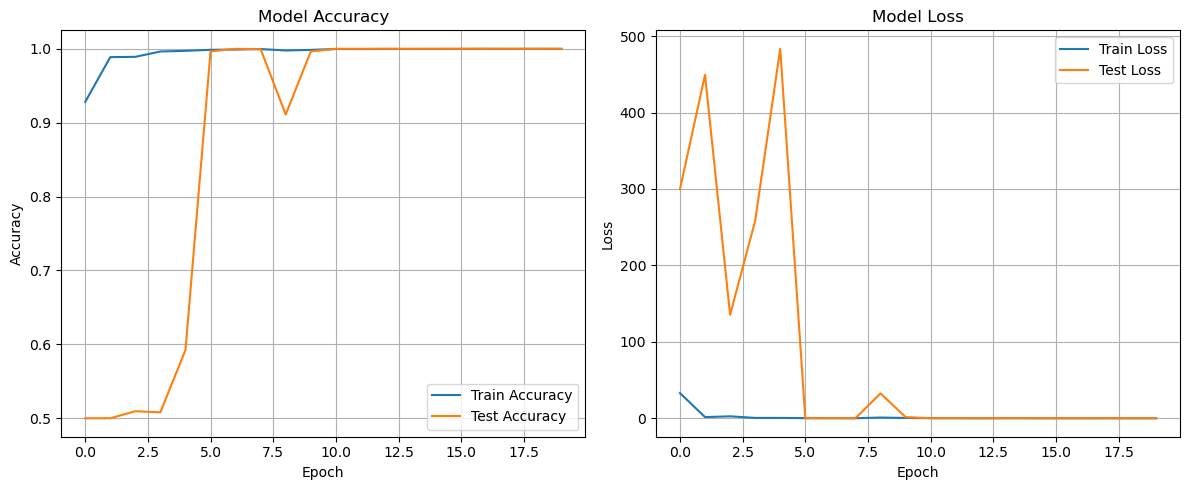

In [27]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


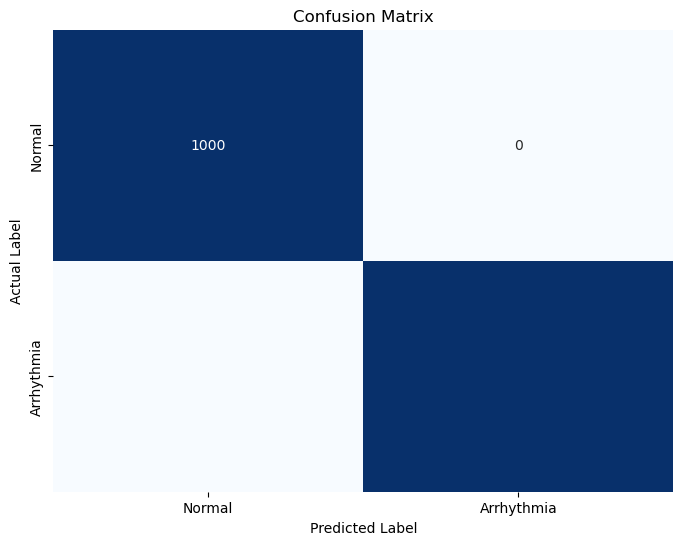

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      1000
  Arrhythmia       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [28]:
# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Confusion matrix plotting function
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', cbar=False,
        xticklabels=class_names, yticklabels=class_names
    )
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['Normal', 'Arrhythmia']

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, class_names)

# Classification report
print(classification_report(y_test, y_pred, target_names=class_names))